In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
sns.set_style('whitegrid')

In [17]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [18]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

In [19]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

In [20]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

In [21]:
model1 = tsa.ARMA(endog=nasdaq_log_diff, order=(2,2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()

In [22]:
model1.params.sort_index() == model2.params.sort_index().values

ar.L1.NASDAQCOM    True
ar.L2.NASDAQCOM    True
const              True
ma.L1.NASDAQCOM    True
ma.L2.NASDAQCOM    True
dtype: bool

In [23]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

In [24]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.761184,1.761184
ar.L2,-0.783701,-0.783701
ma.L1,-0.840799,-0.840799
ma.L2,0.314827,0.314827
sigma2,0.000103,0.000103


In [25]:
train_size = 30
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [26]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           23 non-null     float64
 2   BIC           23 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [27]:
arma_results.nsmallest(5, columns=['RMSE'])

,,RMSE,AIC,BIC,convergence,stationarity
p,q,,,,,
1,0,0.011535,-185.212211,-181.008619,0.0,0.0
2,0,0.012924,-185.671180,-180.066391,0.0,11.0
3,0,0.015486,-185.792514,-178.786528,0.0,12.0
4,0,0.018576,-179.513173,-171.105989,4.0,23.0
0,1,0.026771,-162.623118,-158.419526,0.0,0.0


In [28]:
arma_results.nsmallest(5, columns=['BIC'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
1 0  0.011535 -185.212211 -181.008619          0.0           0.0
2 0  0.012924 -185.671180 -180.066391          0.0          11.0
1 1  0.035331 -185.657196 -180.052406          1.0          38.0
  2  0.032966 -186.267296 -179.261309          0.0          58.0
3 0  0.015486 -185.792514 -178.786528          0.0          12.0

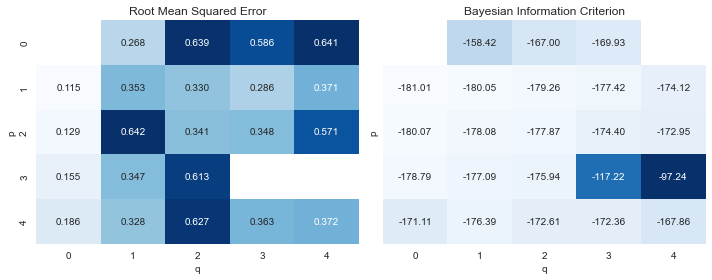

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [30]:
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
1  0    1.0
2  0    2.0
3  0    4.0
1  2    6.0
   3    7.0
dtype: float64

In [31]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [32]:
best_arma_model = tsa.ARMA(endog=industrial_production_log_diff, order=(best_p, best_q)).fit()
print(best_arma_model.summary())

                              ARMA Model Results                              
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                     ARMA(1, 0)   Log Likelihood                1064.232
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 21 Jan 2022   AIC                          -2122.464
Time:                        13:46:49   BIC                          -2110.907
Sample:                    01-01-1989   HQIC                         -2117.863
                         - 12-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0200      0.018      1.128      0.259      -0.015       0.055
ar.L1.IPGMFN     0.9685      0.012     78.280      0.000       0.944       0.993
                                    Roots   

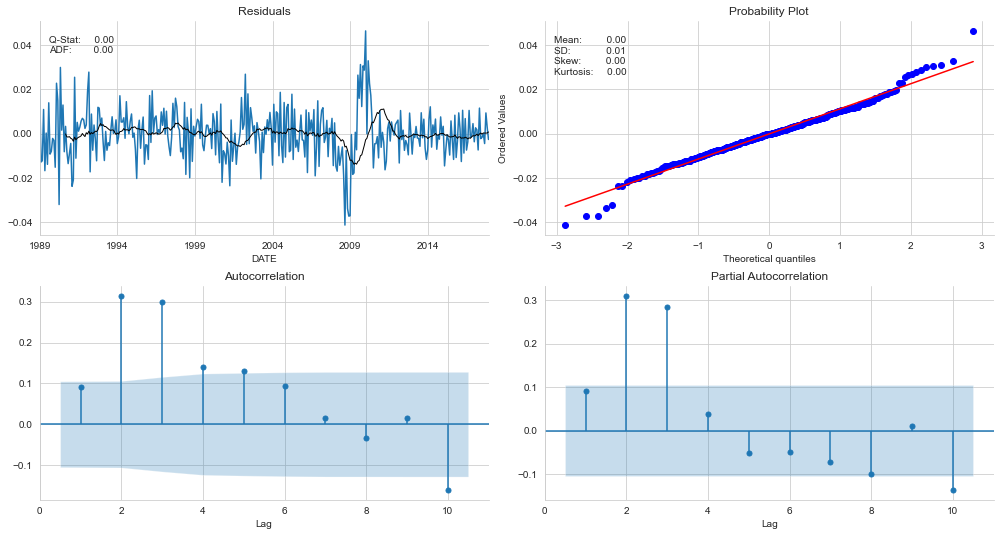

In [33]:
plot_correlogram(best_arma_model.resid)

In [34]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [35]:
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1124.831
Date:                              Fri, 21 Jan 2022   AIC                          -2235.663
Time:                                      13:46:52   BIC                          -2208.697
Sample:                                           0   HQIC                         -2224.927
                                              - 348                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.382      0.018      0.986      -0.742       0.755
ar.L2          0.99

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

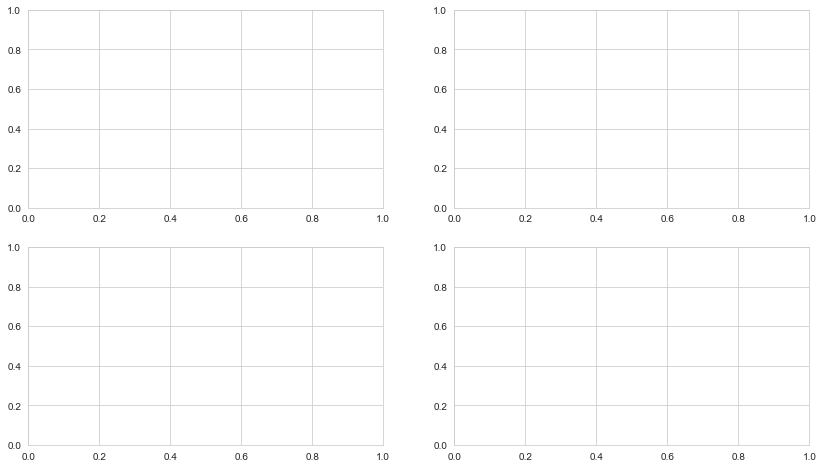

In [36]:
plot_correlogram(sarimax_model.resid)

In [37]:
train_size = 120 # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1 in range(4):
    for q1 in range(4):
        for p2 in range(3):
            for q2 in range(3):
                preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
                aic, bic = [], []
                if p1 == 0 and q1 == 0:
                    continue
                print(p1, q1, p2, q2)
                convergence_error = stationarity_error = 0
                y_pred = []
                for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
                    train_set = industrial_production_log_diff.iloc[T-train_size:T]
                    try:
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore")
                            model = tsa.SARIMAX(endog=train_set.values,
                                            order=(p1, 0, q1),
                                            seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
                    except LinAlgError:
                        convergence_error += 1
                    except ValueError:
                        stationarity_error += 1

                    preds.iloc[i, 1] = model.forecast(steps=1)[0]
                    aic.append(model.aic)
                    bic.append(model.bic)
 
                preds.dropna(inplace=True)
                mse = mean_squared_error(preds.y_true, preds.y_pred)
                results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                                  preds.y_true.sub(preds.y_pred).pow(2).std(),
                                                  np.mean(aic),
                                                  np.std(aic),                                                  
                                                  np.mean(bic),
                                                  np.std(bic),                                                  
                                                  convergence_error,
                                                  stationarity_error]

0 1 0 0


In [ ]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

In [ ]:
with pd.HDFStore('arima.h5') as store:
    store.put('sarimax', sarimax_results)

In [ ]:
with pd.HDFStore('arima.h5') as store:
    sarimax_results = store.get('sarimax')

In [ ]:
sarimax_results.nsmallest(5, columns='RMSE')

In [ ]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

In [ ]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')

In [ ]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [ ]:
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

In [ ]:
p1, q1, p2, q2 = 2, 3, 1, 2

In [ ]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()

In [ ]:
print(best_model.summary())

In [ ]:
plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')